In [3]:
#####################
# Train & Eval
#####################

# coding=utf-8
# Copyright 2021 The Google Research Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Lint as: python3
"""Trains TFT based on a defined set of parameters.
Uses default parameters supplied from the configs file to train a TFT model from
scratch.

Usage:
python3 script_train_fixed_params {expt_name} {output_folder}

Command line args:
  expt_name: Name of dataset/experiment to train.
  output_folder: Root folder in which experiment is saved
"""

import argparse
import datetime as dte
import os,sys
sys.path.append('/tf/crypto_prediction_ml_dl/script')
sys.path.append('/tf/crypto_prediction_ml_dl/notebook/TFT_models')

import data_formatters.base
import expt_settings.configs
import libs.hyperparam_opt
import libs.tft_model
import libs.utils as utils
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf

import tensorflow
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))

ExperimentConfig = expt_settings.configs.ExperimentConfig
HyperparamOptManager = libs.hyperparam_opt.HyperparamOptManager
ModelClass = libs.tft_model.TemporalFusionTransformer
tf.experimental.output_all_intermediates(True)

Num GPUs Available:  1


In [4]:
def main_train(expt_name,
         use_gpu,
         model_folder,
         data_csv_path,
         data_formatter,
         use_testing_mode=False):
    """Trains tft based on defined model params.

    Args:
      expt_name: Name of experiment
      use_gpu: Whether to run tensorflow with GPU operations
      model_folder: Folder path where models are serialized
      data_csv_path: Path to csv file containing data
      data_formatter: Dataset-specific data fromatter (see
        expt_settings.dataformatter.GenericDataFormatter)
      use_testing_mode: Uses a smaller models and data sizes for testing purposes
        only -- switch to False to use original default settings
    """

    num_repeats = 1

    if not isinstance(data_formatter, data_formatters.base.GenericDataFormatter):
        raise ValueError(
            "Data formatters should inherit from" +
            "AbstractDataFormatter! Type={}".format(type(data_formatter)))

    # Tensorflow setup
    default_keras_session = tf.keras.backend.get_session()

    if use_gpu:
        tf_config = utils.get_default_tensorflow_config(tf_device="gpu", gpu_id=0)

    else:
        tf_config = utils.get_default_tensorflow_config(tf_device="cpu")

    print("*** Training from defined parameters for {} ***".format(expt_name))

    print("Loading & splitting data...")
    raw_data = pd.read_csv(data_csv_path, index_col=0)
    train, valid, test = data_formatter.split_data(raw_data)
    train_samples, valid_samples = data_formatter.get_num_samples_for_calibration()

    # Sets up default params
    fixed_params = data_formatter.get_experiment_params()
    params = data_formatter.get_default_model_params()
    params["model_folder"] = model_folder

    # Parameter overrides for testing only! Small sizes used to speed up script.
    if use_testing_mode:
        fixed_params["num_epochs"] = 1
        params["hidden_layer_size"] = 5
        train_samples, valid_samples = 100, 10

    # Sets up hyperparam manager
    print("*** Loading hyperparm manager ***")
    opt_manager = HyperparamOptManager({k: [params[k]] for k in params},
                                       fixed_params, model_folder)


    # Training -- one iteration only
    print("*** Running calibration ***")
    print("Params Selected:")
    for k in params:
        print("{}: {}".format(k, params[k]))

    best_loss = np.Inf
    for _ in range(num_repeats):

        tf.reset_default_graph()
        with tf.Graph().as_default(), tf.Session(config=tf_config) as sess:

            tf.keras.backend.set_session(sess)

            params = opt_manager.get_next_parameters()
            model = ModelClass(params, use_cudnn=use_gpu)

            if not model.training_data_cached():
                model.cache_batched_data(train, "train", num_samples=train_samples)
                model.cache_batched_data(valid, "valid", num_samples=valid_samples)

            sess.run(tf.global_variables_initializer())
            model.fit()

            val_loss = model.evaluate()

            if val_loss < best_loss:
                opt_manager.update_score(params, val_loss, model)
                best_loss = val_loss

            tf.keras.backend.set_session(default_keras_session)

    print("*** Running tests ***")
    tf.reset_default_graph()
    with tf.Graph().as_default(), tf.Session(config=tf_config) as sess:
        tf.keras.backend.set_session(sess)
        best_params = opt_manager.get_best_params()
        model = ModelClass(best_params, use_cudnn=use_gpu)

        model.load(opt_manager.hyperparam_folder)

        print("Computing best validation loss")
        val_loss = model.evaluate(valid)

        print("Computing test loss")
        output_map = model.predict(test, return_targets=True)
        targets = data_formatter.format_predictions(output_map["targets"])
        p50_forecast = data_formatter.format_predictions(output_map["p50"])
        p90_forecast = data_formatter.format_predictions(output_map["p90"])

        def extract_numerical_data(data):
            """Strips out forecast time and identifier columns."""
            return data[[
                col for col in data.columns
                if col not in {"forecast_time", "identifier"}
            ]]

        p50_loss = utils.numpy_normalised_quantile_loss(
            extract_numerical_data(targets), extract_numerical_data(p50_forecast), 0.5)
        p90_loss = utils.numpy_normalised_quantile_loss(
            extract_numerical_data(targets), extract_numerical_data(p90_forecast), 0.9)

        tf.keras.backend.set_session(default_keras_session)

    print("Training completed @ {}".format(dte.datetime.now()))
    print("Best validation loss = {}".format(val_loss))
    print("Params:")

    for k in best_params:
        print(k, " = ", best_params[k])
    print()
    print("Normalised Quantile Loss for Test Data: P50={}, P90={}".format(
        p50_loss.mean(), p90_loss.mean()))
    
    return output_map



In [5]:
dataset_name = 'crypto_minute'
output_folder = '.'
use_tensorflow_with_gpu = 'yes'

print("Using output folder {}".format(output_folder))

config = ExperimentConfig(dataset_name, output_folder)
formatter = config.make_data_formatter()

# Customise inputs to main() for new datasets.
output_map = main_train(
    expt_name=dataset_name,
    use_gpu=use_tensorflow_with_gpu,
    model_folder=os.path.join(config.model_folder, "fixed"),
    data_csv_path=config.data_csv_path,
    data_formatter=formatter,
    use_testing_mode=False)  # Change to false to use original default params

Using output folder .


2023-11-23 05:20:15.952146: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-23 05:20:15.952450: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-23 05:20:15.952655: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Selecting GPU ID=0
*** Training from defined parameters for crypto_minute ***
Loading & splitting data...
Formatting train-valid-test splits.
Setting scalers with training data...
*** Loading hyperparm manager ***
*** Running calibration ***
Params Selected:
dropout_rate: 0.5
hidden_layer_size: 10
learning_rate: 0.01
minibatch_size: 64
max_gradient_norm: 100.0
num_heads: 1
stack_size: 1
model_folder: ./saved_models/crypto_minute/fixed
Resetting temp folder...
*** TemporalFusionTransformer params ***
# dropout_rate = 0.5
# hidden_layer_size = 10
# learning_rate = 0.01
# max_gradient_norm = 100.0
# minibatch_size = 64
# model_folder = ./saved_models/crypto_minute/fixed
# num_heads = 1
# stack_size = 1
# total_time_steps = 70
# num_encoder_steps = 60
# num_epochs = 100
# early_stopping_patience = 5
# multiprocessing_workers = 5
# column_definition = [('symbol_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.ID: 4>), ('ts', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>), ('row_id', <DataTypes.REAL

2023-11-23 05:20:16.700333: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_2/stack_1' id:12 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_2/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 0 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-23 05:20:16.702409: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_2/stack_2' id:13 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_2/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 1 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation 

2023-11-23 05:20:16.902713: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_7/bias/Assign' id:346 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_7/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_7/bias, TemporalFusionTransformer/time_distributed_7/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-23 05:20:16.908933: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_11/stack_1' id:359 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_11/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type:

2023-11-23 05:20:17.107376: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_18/stack_1' id:633 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_18/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 0 4>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-23 05:20:17.112812: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_18/stack_2' id:634 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_18/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutatio

2023-11-23 05:20:17.698077: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/ExpandDims_1/dim' id:1723 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/ExpandDims_1/dim}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-23 05:20:17.718440: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_16/bias/Assign' id:1794 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_16/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_16/bias, TemporalFusionTransformer/time_distributed_16/bia

2023-11-23 05:20:18.418613: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_37/bias/Assign' id:2723 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_37/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_37/bias, TemporalFusionTransformer/time_distributed_37/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-23 05:20:18.460359: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_28/stack_1' id:2785 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_28/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor

2023-11-23 05:20:19.289971: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_32/stack_2' id:3558 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_32/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-23 05:20:19.415816: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_55/kernel/Assign' id:3616 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_55/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_55/kernel, TemporalFusionTransforme

2023-11-23 05:20:20.489200: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_37/stack_1' id:4522 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_37/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 0 14>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-23 05:20:20.541351: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_37/stack_2' id:4523 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_37/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This muta

2023-11-23 05:20:21.784481: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_87/bias/Assign' id:5170 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_87/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_87/bias, TemporalFusionTransformer/time_distributed_87/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-23 05:20:21.972626: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_91/kernel/Assign' id:5291 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_91/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true,

2023-11-23 05:20:23.601710: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/eye/diag/num_cols' id:6245 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/eye/diag/num_cols}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: -1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-23 05:20:23.679138: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/eye/diag/padding_value' id:6246 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/eye/diag/padding_value}} = Const[_has_manual_control_dependencies=true, dtype=DT_FLOAT, value=Tensor<type: float shape: [] values: 0>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 70, 17)]             0         []                            
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 70, 17)]             0         ['input_1[0][0]']             
 Transformer/strided_slice                                                                        
 (TensorFlowOpLayer)                                                                              
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1)]                  0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/strided_slice[0]

 Transformer/concat_1/conca                                         ]                             
 t (TensorFlowOpLayer)                                                                            
                                                                                                  
 multiply_2 (Multiply)       (None, 1, 10)                0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/ExpandDims[0][0]',  
                                                                     'tf_op_layer_TemporalFusionTr
                                                                    ansformer/concat_1/concat[0][0
                                                                    ]']                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 10)]                 0         ['multiply_2[0][0]']          
 Transform

                                                                                                  
 dropout_2 (Dropout)         (None, 10)                   0         ['dense_27[0][0]']            
                                                                                                  
 time_distributed_1 (TimeDi  (None, 70, 10)               20        ['tf_op_layer_TemporalFusionTr
 stributed)                                                         ansformer/strided_slice_4[0][0
                                                                    ]']                           
                                                                                                  
 time_distributed_2 (TimeDi  (None, 70, 10)               20        ['tf_op_layer_TemporalFusionTr
 stributed)                                                         ansformer/strided_slice_5[0][0
                                                                    ]']                           
          

                                                                     'time_distributed_13[0][0]', 
                                                                     'time_distributed_14[0][0]'] 
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 70, 10, 1)]          0         ['time_distributed_15[0][0]'] 
 Transformer/stack_3 (Tenso                                                                       
 rFlowOpLayer)                                                                                    
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 70, 10, 1)]          0         ['time_distributed[0][0]']    
 Transformer/stack_1 (Tenso                                                                       
 rFlowOpLayer)                                                                                    
          

 26 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 60, 10)]             0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 27 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 60, 10)]             0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 28 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_lay

 time_distributed_42 (TimeD  (None, 60, 10)               110       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_29[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_46 (TimeD  (None, 60, 10)               110       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_30[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_50 (TimeD  (None, 60, 10)               110       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_31[0][
          

2023-11-23 05:20:24.787114: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_47/stack_2' id:6872 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_47/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 1 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


 activation_23 (Activation)  (None, 60, 10)               0         ['time_distributed_78[0][0]'] 
                                                                                                  
 activation_24 (Activation)  (None, 60, 10)               0         ['time_distributed_82[0][0]'] 
                                                                                                  
 activation_25 (Activation)  (None, 10, 10)               0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/add_23[0][0]']      
                                                                                                  
 time_distributed_92 (TimeD  (None, 10, 10)               110       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_40[0][
                                                                    0]']                          
          

                                                                                                  
 dropout_13 (Dropout)        (None, 60, 10)               0         ['time_distributed_47[0][0]'] 
                                                                                                  
 dropout_14 (Dropout)        (None, 60, 10)               0         ['time_distributed_51[0][0]'] 
                                                                                                  
 dropout_15 (Dropout)        (None, 60, 10)               0         ['time_distributed_55[0][0]'] 
                                                                                                  
 dropout_16 (Dropout)        (None, 60, 10)               0         ['time_distributed_59[0][0]'] 
                                                                                                  
 dropout_17 (Dropout)        (None, 60, 10)               0         ['time_distributed_63[0][0]'] 
          

 time_distributed_53 (TimeD  (None, 60, 10)               110       ['dropout_14[0][0]']          
 istributed)                                                                                      
                                                                                                  
 time_distributed_56 (TimeD  (None, 60, 10)               110       ['dropout_15[0][0]']          
 istributed)                                                                                      
                                                                                                  
 time_distributed_57 (TimeD  (None, 60, 10)               110       ['dropout_15[0][0]']          
 istributed)                                                                                      
                                                                                                  
 time_distributed_60 (TimeD  (None, 60, 10)               110       ['dropout_16[0][0]']          
 istribute

                                                                                                  
 multiply_14 (Multiply)      (None, 60, 10)               0         ['time_distributed_48[0][0]', 
                                                                     'time_distributed_49[0][0]'] 
                                                                                                  
 multiply_15 (Multiply)      (None, 60, 10)               0         ['time_distributed_52[0][0]', 
                                                                     'time_distributed_53[0][0]'] 
                                                                                                  
 multiply_16 (Multiply)      (None, 60, 10)               0         ['time_distributed_56[0][0]', 
                                                                     'time_distributed_57[0][0]'] 
                                                                                                  
 multiply_

                                                                     'multiply_14[0][0]']         
                                                                                                  
 add_14 (Add)                (None, 60, 10)               0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/strided_slice_31[0][
                                                                    0]',                          
                                                                     'multiply_15[0][0]']         
                                                                                                  
 add_15 (Add)                (None, 60, 10)               0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/strided_slice_32[0][
                                                                    0]',                          
          

                                                                                                  
 layer_normalization_15 (La  (None, 60, 10)               20        ['add_15[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 layer_normalization_16 (La  (None, 60, 10)               20        ['add_16[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 layer_normalization_17 (La  (None, 60, 10)               20        ['add_17[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 layer_nor

                                                                    ']                            
                                                                                                  
 layer_normalization_24 (La  (None, 10, 10)               20        ['add_24[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 multiply_24 (Multiply)      (None, 60, 10, 16)           0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/ExpandDims_2[0][0]',
                                                                     'tf_op_layer_TemporalFusionTr
                                                                    ansformer/stack_4[0][0]']     
                                                                                                  
 add_4 (Ad

                                                                     'dense_33[0][0]']            
                                                                                                  
 multiply_28 (Multiply)      (None, 70, 10)               0         ['time_distributed_96[0][0]', 
                                                                     'time_distributed_97[0][0]'] 
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 70, 10)]             0         ['tf_op_layer_TemporalFusionTr
 Transformer/concat_3 (Tens                                         ansformer/Sum_1[0][0]',       
 orFlowOpLayer)                                                      'tf_op_layer_TemporalFusionTr
                                                                    ansformer/Sum_2[0][0]']       
                                                                                                  
 add_3 (Ad

 42 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(1,)]                       0         ['tf_op_layer_TemporalFusionTr
 Transformer/eye/concat/val                                         ansformer/eye/Minimum[0][0]'] 
 ues_1 (TensorFlowOpLayer)                                                                        
                                                                                                  
 tf_op_layer_TemporalFusion  [(2,)]                       0         ['tf_op_layer_TemporalFusionTr
 Transformer/eye/concat (Te                                         ansformer/strided_slice_42[0][
 nsorFlowOpLayer)                                                   0]',                          
                                                                     'tf_op_layer_TemporalFusionTr
          

                                                                                                  
 time_distributed_107 (Time  (None, 70, 10)               110       ['dropout_31[0][0]']          
 Distributed)                                                                                     
                                                                                                  
 time_distributed_108 (Time  (None, 70, 10)               110       ['dropout_31[0][0]']          
 Distributed)                                                                                     
                                                                                                  
 multiply_31 (Multiply)      (None, 70, 10)               0         ['time_distributed_107[0][0]',
                                                                     'time_distributed_108[0][0]']
                                                                                                  
 add_29 (A

2023-11-23 05:20:27.801411: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/layer_normalization_29/beta/Assign' id:6820 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/layer_normalization_29/beta/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/layer_normalization_29/beta, TemporalFusionTransformer/layer_normalization_29/beta/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


*** Fitting TemporalFusionTransformer ***
Getting batched_data
Using cached training data
Using cached validation data
Using keras standard fit
Train on 89931 samples, validate on 9931 samples
Epoch 1/100


2023-11-23 05:20:30.700722: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/loss/mul' id:7012 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](TemporalFusionTransformer/loss/mul/x, TemporalFusionTransformer/loss/time_distributed_111_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-23 05:20:31.233244: W tensorflow/c/c_api.cc:304] Operation '{name:'training/Adam/TemporalFusionTransformer/time_distributed_105/bias/m/Assign' id:12186 op device:{requested: '', assigned: ''} def:{{{node training/Adam/TemporalFusionTransformer/time_distributed_105/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/TemporalFusionTransfo

89931/89931 [==============================] - ETA: 0s - loss: 0.0344

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-11-23 05:21:18.343765: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/loss/mul' id:7012 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](TemporalFusionTransformer/loss/mul/x, TemporalFusionTransformer/loss/time_distributed_111_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


89931/89931 [==============================] - 51s 566us/sample - loss: 0.0344 - val_loss: 0.1622
Epoch 2/100
89931/89931 [==============================] - 44s 491us/sample - loss: 0.0135 - val_loss: 0.2333
Epoch 3/100
89931/89931 [==============================] - 44s 493us/sample - loss: 0.0105 - val_loss: 0.1626
Epoch 4/100
89931/89931 [==============================] - 44s 494us/sample - loss: 0.0100 - val_loss: 0.0947
Epoch 5/100
89931/89931 [==============================] - 44s 491us/sample - loss: 0.0092 - val_loss: 0.0967
Epoch 6/100
89931/89931 [==============================] - 44s 492us/sample - loss: 0.0089 - val_loss: 0.0712
Epoch 7/100
89931/89931 [==============================] - 45s 498us/sample - loss: 0.0083 - val_loss: 0.0650
Epoch 8/100
89931/89931 [==============================] - 44s 493us/sample - loss: 0.0080 - val_loss: 0.0346
Epoch 9/100
89931/89931 [==============================] - 45s 496us/sample - loss: 0.0077 - val_loss: 0.0212
Epoch 10/100
89931/899

2023-11-23 05:34:43.763458: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-23 05:34:43.764501: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-23 05:34:43.764797: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

2023-11-23 05:34:43.977485: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_7/kernel/Assign' id:341 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_7/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_7/kernel, TemporalFusionTransformer/time_distributed_7/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-23 05:34:43.985047: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_11/stack_1' id:359 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_11/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=D

2023-11-23 05:34:44.183332: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_17/stack_1' id:593 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_17/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 0 16>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-23 05:34:44.189883: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_17/stack_2' id:594 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_17/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutati

2023-11-23 05:34:44.848027: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/ExpandDims_1/dim' id:1723 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/ExpandDims_1/dim}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-23 05:34:44.870950: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_17/bias/Assign' id:1823 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_17/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_17/bias, TemporalFusionTransformer/time_distributed_17/bia

2023-11-23 05:34:45.600361: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_37/bias/Assign' id:2723 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_37/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_37/bias, TemporalFusionTransformer/time_distributed_37/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-23 05:34:45.647701: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_28/stack_1' id:2785 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_28/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor

2023-11-23 05:34:46.505207: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_32/stack_2' id:3558 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_32/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-23 05:34:46.638074: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_56/kernel/Assign' id:3654 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_56/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_56/kernel, TemporalFusionTransforme

2023-11-23 05:34:47.965827: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_74/bias/Assign' id:4556 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_74/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_74/bias, TemporalFusionTransformer/time_distributed_74/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-23 05:34:48.041139: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_38/stack_1' id:4715 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_38/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor

2023-11-23 05:34:49.441740: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/ExpandDims_4/dim' id:5358 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/ExpandDims_4/dim}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: 2>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-23 05:34:49.515006: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_92/bias/Assign' id:5394 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_92/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_92/bias, TemporalFusionTransformer/time_distributed_92/bia

2023-11-23 05:34:51.104345: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/eye/concat/axis' id:6239 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/eye/concat/axis}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: 0>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-23 05:34:51.184154: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_42/stack' id:6233 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_42/stack}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [1] values: 0>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, an

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 70, 17)]             0         []                            
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 70, 17)]             0         ['input_1[0][0]']             
 Transformer/strided_slice                                                                        
 (TensorFlowOpLayer)                                                                              
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1)]                  0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/strided_slice[0]

 Transformer/concat_1/conca                                         ]                             
 t (TensorFlowOpLayer)                                                                            
                                                                                                  
 multiply_2 (Multiply)       (None, 1, 10)                0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/ExpandDims[0][0]',  
                                                                     'tf_op_layer_TemporalFusionTr
                                                                    ansformer/concat_1/concat[0][0
                                                                    ]']                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 10)]                 0         ['multiply_2[0][0]']          
 Transform

                                                                                                  
 dropout_2 (Dropout)         (None, 10)                   0         ['dense_27[0][0]']            
                                                                                                  
 time_distributed_1 (TimeDi  (None, 70, 10)               20        ['tf_op_layer_TemporalFusionTr
 stributed)                                                         ansformer/strided_slice_4[0][0
                                                                    ]']                           
                                                                                                  
 time_distributed_2 (TimeDi  (None, 70, 10)               20        ['tf_op_layer_TemporalFusionTr
 stributed)                                                         ansformer/strided_slice_5[0][0
                                                                    ]']                           
          

                                                                     'time_distributed_13[0][0]', 
                                                                     'time_distributed_14[0][0]'] 
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 70, 10, 1)]          0         ['time_distributed_15[0][0]'] 
 Transformer/stack_3 (Tenso                                                                       
 rFlowOpLayer)                                                                                    
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 70, 10, 1)]          0         ['time_distributed[0][0]']    
 Transformer/stack_1 (Tenso                                                                       
 rFlowOpLayer)                                                                                    
          

 26 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 60, 10)]             0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 27 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 60, 10)]             0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 28 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_lay

 time_distributed_42 (TimeD  (None, 60, 10)               110       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_29[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_46 (TimeD  (None, 60, 10)               110       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_30[0][
                                                                    0]']                          


2023-11-23 05:34:52.075861: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_47/stack_2' id:6872 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_47/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 1 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


                                                                                                  
 time_distributed_50 (TimeD  (None, 60, 10)               110       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_31[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_54 (TimeD  (None, 60, 10)               110       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_32[0][
                                                                    0]']                          
                                                                                                  
 time_distributed_58 (TimeD  (None, 60, 10)               110       ['tf_op_layer_TemporalFusionTr
 istribute

 time_distributed_92 (TimeD  (None, 10, 10)               110       ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/strided_slice_40[0][
                                                                    0]']                          
                                                                                                  
 dropout_6 (Dropout)         (None, 60, 10)               0         ['time_distributed_19[0][0]'] 
                                                                                                  
 time_distributed_23 (TimeD  (None, 60, 10)               110       ['activation_9[0][0]']        
 istributed)                                                                                      
                                                                                                  
 time_distributed_27 (TimeD  (None, 60, 10)               110       ['activation_10[0][0]']       
 istribute

 dropout_16 (Dropout)        (None, 60, 10)               0         ['time_distributed_59[0][0]'] 
                                                                                                  
 dropout_17 (Dropout)        (None, 60, 10)               0         ['time_distributed_63[0][0]'] 
                                                                                                  
 dropout_18 (Dropout)        (None, 60, 10)               0         ['time_distributed_67[0][0]'] 
                                                                                                  
 dropout_19 (Dropout)        (None, 60, 10)               0         ['time_distributed_71[0][0]'] 
                                                                                                  
 dropout_20 (Dropout)        (None, 60, 10)               0         ['time_distributed_75[0][0]'] 
                                                                                                  
 dropout_2

 istributed)                                                                                      
                                                                                                  
 time_distributed_60 (TimeD  (None, 60, 10)               110       ['dropout_16[0][0]']          
 istributed)                                                                                      
                                                                                                  
 time_distributed_61 (TimeD  (None, 60, 10)               110       ['dropout_16[0][0]']          
 istributed)                                                                                      
                                                                                                  
 time_distributed_64 (TimeD  (None, 60, 10)               110       ['dropout_17[0][0]']          
 istributed)                                                                                      
          

 multiply_16 (Multiply)      (None, 60, 10)               0         ['time_distributed_56[0][0]', 
                                                                     'time_distributed_57[0][0]'] 
                                                                                                  
 multiply_17 (Multiply)      (None, 60, 10)               0         ['time_distributed_60[0][0]', 
                                                                     'time_distributed_61[0][0]'] 
                                                                                                  
 multiply_18 (Multiply)      (None, 60, 10)               0         ['time_distributed_64[0][0]', 
                                                                     'time_distributed_65[0][0]'] 
                                                                                                  
 multiply_19 (Multiply)      (None, 60, 10)               0         ['time_distributed_68[0][0]', 
          

 add_15 (Add)                (None, 60, 10)               0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/strided_slice_32[0][
                                                                    0]',                          
                                                                     'multiply_16[0][0]']         
                                                                                                  
 add_16 (Add)                (None, 60, 10)               0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/strided_slice_33[0][
                                                                    0]',                          
                                                                     'multiply_17[0][0]']         
                                                                                                  
 add_17 (A

 layer_normalization_17 (La  (None, 60, 10)               20        ['add_17[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 layer_normalization_18 (La  (None, 60, 10)               20        ['add_18[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 layer_normalization_19 (La  (None, 60, 10)               20        ['add_19[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 layer_normalization_20 (La  (None, 60, 10)               20        ['add_20[0][0]']              
 yerNormal

                                                                     'tf_op_layer_TemporalFusionTr
                                                                    ansformer/stack_4[0][0]']     
                                                                                                  
 add_4 (Add)                 (None, 10)                   0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/Sum[0][0]',         
                                                                     'multiply_5[0][0]']          
                                                                                                  
 add_5 (Add)                 (None, 10)                   0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/Sum[0][0]',         
                                                                     'multiply_6[0][0]']          
          

 orFlowOpLayer)                                                      'tf_op_layer_TemporalFusionTr
                                                                    ansformer/Sum_2[0][0]']       
                                                                                                  
 add_3 (Add)                 (None, 10)                   0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/Sum[0][0]',         
                                                                     'multiply_4[0][0]']          
                                                                                                  
 add_25 (Add)                (None, 70, 10)               0         ['multiply_28[0][0]',         
                                                                     'tf_op_layer_TemporalFusionTr
                                                                    ansformer/concat_3[0][0]']    
          

 Transformer/eye/concat (Te                                         ansformer/strided_slice_42[0][
 nsorFlowOpLayer)                                                   0]',                          
                                                                     'tf_op_layer_TemporalFusionTr
                                                                    ansformer/eye/concat/values_1[
                                                                    0][0]']                       
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 70)]                 0         ['tf_op_layer_TemporalFusionTr
 Transformer/eye/ones (Tens                                         ansformer/eye/concat[0][0]']  
 orFlowOpLayer)                                                                                   
                                                                                                  
 tf_op_lay

 multiply_31 (Multiply)      (None, 70, 10)               0         ['time_distributed_107[0][0]',
                                                                     'time_distributed_108[0][0]']
                                                                                                  
 add_29 (Add)                (None, 70, 10)               0         ['layer_normalization_27[0][0]
                                                                    ',                            
                                                                     'multiply_31[0][0]']         
                                                                                                  
 layer_normalization_28 (La  (None, 70, 10)               20        ['add_29[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 time_dist

2023-11-23 05:34:52.543150: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_111/bias/Assign' id:6918 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_111/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_111/bias, TemporalFusionTransformer/time_distributed_111/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Loading model from ./saved_models/crypto_minute/fixed/TemporalFusionTransformer.ckpt
tensor: TemporalFusionTransformer/cu_dnnlstm/bias (float32) [80]
[-0.18469208  0.10945754  0.20582563 -0.7001489  -0.4068019  -1.3237926
 -0.9939613  -0.54425055 -0.24724428 -0.08655158  0.7211406   0.56550467
  0.15584226 -0.54177415  0.35426024 -0.7616415  -1.0623382  -1.187289
 -0.56732935  0.45929277  0.08794424 -0.39643326 -0.8560461   0.37253872
 -0.40062913 -0.33153018 -0.04686367  0.10941122 -0.5699443   0.35028285
 -1.1101747  -1.2316104  -1.1330954  -1.1206403  -0.1060502  -0.3339825
  0.02333708  0.5395474  -1.04063    -0.15330686 -0.18469208  0.10945754
  0.20582563 -0.7001489  -0.4068019  -1.3237926  -0.9939613  -0.54425055
 -0.24724428 -0.08655158  1.7211379   1.5655098   1.1558418   0.4582268
  1.354259    0.23835763 -0.06234103 -0.18728787  0.43267417  1.4592957
  0.08794424 -0.39643326 -0.8560461   0.37253872 -0.40062913 -0.33153018
 -0.04686367  0.10941122 -0.5699443   0.35028285 -1.1

Done.
Computing best validation loss


/usr/local/lib/python3.8/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-11-23 05:34:53.372530: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/loss/mul' id:7012 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](TemporalFusionTransformer/loss/mul/x, TemporalFusionTransformer/loss/time_distributed_111_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Computing test loss


/usr/local/lib/python3.8/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-11-23 05:34:55.874903: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_111/Reshape_1' id:6927 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_111/Reshape_1}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _has_manual_control_dependencies=true](TemporalFusionTransformer/time_distributed_111/dense_141/BiasAdd, TemporalFusionTransformer/time_distributed_111/Reshape_1/shape)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Training completed @ 2023-11-23 05:34:57.271248
Best validation loss = 0.07872893788650454
Params:
dropout_rate  =  0.5
hidden_layer_size  =  10
learning_rate  =  0.01
max_gradient_norm  =  100.0
minibatch_size  =  64
model_folder  =  ./saved_models/crypto_minute/fixed
num_heads  =  1
stack_size  =  1
total_time_steps  =  70
num_encoder_steps  =  60
num_epochs  =  100
early_stopping_patience  =  5
multiprocessing_workers  =  5
column_definition  =  [('symbol_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.ID: 4>), ('ts', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>), ('row_id', <DataTypes.REAL_VALUED: 0>, <InputTypes.STATIC_INPUT: 3>), ('low', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('high', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('open', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('close', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('total_volume', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('total

In [6]:
output_map

{'p10':              forecast_time identifier       t+0       t+1       t+2       t+3  \
 0      2023-11-15 22:20:00   BTC_USDT  2.567849  2.573290  2.578400  2.577065   
 1      2023-11-15 22:21:00   BTC_USDT  2.572354  2.578683  2.577044  2.572045   
 2      2023-11-15 22:22:00   BTC_USDT  2.577732  2.577318  2.572023  2.584966   
 3      2023-11-15 22:23:00   BTC_USDT  2.576383  2.572289  2.584943  2.598540   
 4      2023-11-15 22:24:00   BTC_USDT  2.571386  2.585236  2.598516  2.612181   
 ...                    ...        ...       ...       ...       ...       ...   
 10214  2023-11-23 00:46:00   BTC_USDT  2.490173  2.495553  2.502712  2.499597   
 10215  2023-11-23 00:47:00   BTC_USDT  2.494963  2.502910  2.499582  2.504390   
 10216  2023-11-23 00:48:00   BTC_USDT  2.502262  2.499782  2.504376  2.495045   
 10217  2023-11-23 00:49:00   BTC_USDT  2.499114  2.504579  2.495029  2.491160   
 10218  2023-11-23 00:50:00   BTC_USDT  2.503961  2.495212  2.491145  2.488281   
 
       

In [8]:
plot_time_point = 't+9'

targets = formatter.format_predictions(output_map["targets"])

real_close = pd.DataFrame(targets['forecast_time'])
real_close["real_close"] = targets[plot_time_point]

p10_forecast = formatter.format_predictions(output_map["p10"])
p10_forecast_close = p10_forecast[plot_time_point]

p50_forecast = formatter.format_predictions(output_map["p50"])
p50_forecast_close = p50_forecast[plot_time_point]

p90_forecast = formatter.format_predictions(output_map["p90"])
p90_forecast_close = p90_forecast[plot_time_point]

real_and_pred_results = real_close
real_and_pred_results['p10_forecast_close'] = p10_forecast_close
real_and_pred_results['p50_forecast_close'] = p50_forecast_close
real_and_pred_results['p90_forecast_close'] = p90_forecast_close
real_and_pred_results.set_index(['forecast_time'])

,real_close,p10_forecast_close,p50_forecast_close,p90_forecast_close
forecast_time,,,,
2023-11-15 22:20:00,37670.73,37224.519531,37341.035156,37492.230469
2023-11-15 22:21:00,37681.74,37240.683594,37357.382812,37508.718750
2023-11-15 22:22:00,37702.11,37248.527344,37365.312500,37516.718750
2023-11-15 22:23:00,37708.91,37252.976562,37369.812500,37521.257812
2023-11-15 22:24:00,37683.59,37274.988281,37392.074219,37543.714844
...,...,...,...,...
2023-11-23 00:46:00,37255.62,36837.289062,36949.761719,37097.523438
2023-11-23 00:47:00,37260.31,36854.753906,36967.398438,37115.316406
2023-11-23 00:48:00,37252.99,36847.691406,36960.261719,37108.121094


<Axes: >

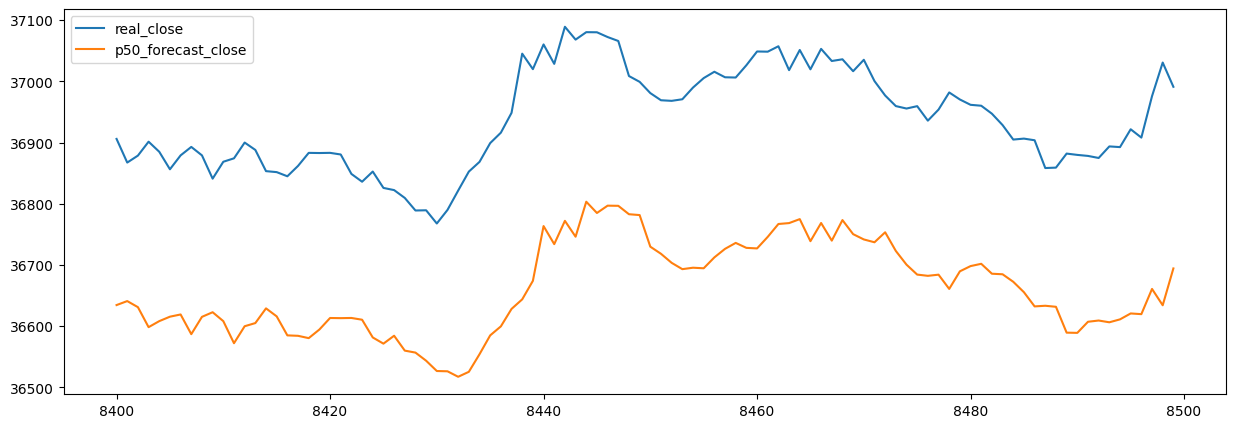

In [11]:
real_and_pred_results[['real_close','p50_forecast_close']][8400:8500].plot(figsize=(15,5))